# Env v2
Implement everything with just convolutions to easily scale up to multiple games at once

In [1]:
import torch
from torch.nn.functional import conv2d, relu
import matplotlib.pyplot as plt

In [2]:
SIZE = 12
FOOD_CHANNEL = 0
FOOD_REWARD = 1
HEAD_CHANNEL = 1
BODY_CHANNEL = 2
OPPOSITE_DIRECTION = {
    'up': 'down',
    'down': 'up',
    'left': 'right',
    'right': 'left'
}
DIRECTION_TO_CONV = {
    'up': torch.tensor([
        [0, 1, 0],
        [0, 0, 0],
        [0, 0, 0],
    ]).float().unsqueeze(0).unsqueeze(0),
    'right': torch.tensor([
        [0, 0, 0],
        [1, 0, 0],
        [0, 0, 0],
    ]).float().unsqueeze(0).unsqueeze(0),
    'down': torch.tensor([
        [0, 0, 0],
        [0, 0, 0],
        [0, 1, 0],
    ]).float().unsqueeze(0).unsqueeze(0),
    'left': torch.tensor([
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 0],
    ]).float().unsqueeze(0).unsqueeze(0),
}
NO_CHANGE_CONV = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0],
]).float().unsqueeze(0).unsqueeze(0)
EMPTY_CONV = torch.tensor([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
]).float().unsqueeze(0).unsqueeze(0)

In [3]:
def get_test_world():
    # Channels:
    # 0: Food
    # 1: Snake
    world  = torch.zeros((1, 3, SIZE, SIZE))
    world[0, BODY_CHANNEL, 3, 3] = 1
    world[0, BODY_CHANNEL, 3, 4] = 2
    world[0, BODY_CHANNEL, 4, 4] = 3
    world[0, BODY_CHANNEL, 5, 4] = 4
    world[0, HEAD_CHANNEL, 5, 4] = 1

    world[0, FOOD_CHANNEL, 6, 6] = 1
    
    return world

def plot_world(world, mode='single'):
    if mode == 'single':
        img = (world[0, BODY_CHANNEL, :, :].numpy() > 0) * 0.5
        img += world[0, HEAD_CHANNEL, :, :].numpy() * 0.5
        img += world[0, FOOD_CHANNEL, :, :].numpy() * 1.5
        plt.imshow(img, vmin=0, vmax=1.5)
        plt.xlim((0, SIZE-1))
        plt.ylim((0, SIZE-1))
        plt.grid()
    if mode == 'multi':
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for i, title in zip(range(3), ['Food','Head','Body']):
            axes[i].set_title(title)
            axes[i].imshow(world[0, i, : ,:].numpy())
            axes[i].grid()
            axes[i].set_xlim((0, SIZE-1))
            axes[i].set_ylim((0, SIZE-1))


In [4]:
def food(world):
    return world[:, FOOD_CHANNEL:FOOD_CHANNEL+1]

def head(world):
    return world[:, HEAD_CHANNEL:HEAD_CHANNEL+1]

def body(world):
    return world[:, BODY_CHANNEL:BODY_CHANNEL+1]

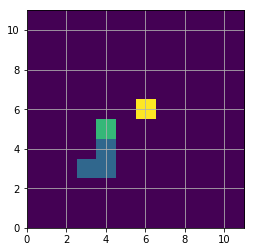

In [5]:
plot_world(get_test_world())

In [16]:
def step_world(world, direction):
    reward = 0.
    done = False
    
    snake_size = world[:, BODY_CHANNEL].view(test_world.shape[0], -1).max(dim=1)[0]
    
    # Move head position with convolution
    weight = torch.cat([NO_CHANGE_CONV, DIRECTION_TO_CONV[direction], NO_CHANGE_CONV], dim=0)
    world = conv2d(
        world,
        weight,
        padding=1, groups=3
    )
    
    # Check for moving "backwards"
    moving_backwards = (head(world) * body(world)).sum() == snake_size - 1
    if bool(moving_backwards):
        print('Moving backwards')

     # Check for hitting self
    hit_self = (head(world) * body(world)).sum() > 0
    done |= bool(hit_self)
    if bool(hit_self):
        print('Hit self')

    ################
    # Apply update #
    ################
    
    # Decay the body sizes by 1, hence moving the body
    body_movement = torch.zeros_like(world)
    body_movement[:, BODY_CHANNEL, :, :] = -1
    world = relu(world + body_movement)
    # Create a new head position in the body channel
    world[:, BODY_CHANNEL:BODY_CHANNEL+1, :, :] += head(world) * snake_size
    # Apply food growth i.e. +1 to all snake locations
    world[:, BODY_CHANNEL:BODY_CHANNEL+1, :, :] += \
        ((head(world) * food(world)).sum() > 0) * body(world).clamp(0, 1)
   
    # Remove food if neccessary
    food_removal = head(world) * food(world) * -1
    world[:, FOOD_CHANNEL:FOOD_CHANNEL+1, :, :] += food_removal
    # Add new food if necessary
    pass  # Add a random food location multipled by ((head * food).sum() > 0)

    # Check for boundary, Done by performing a convolution with no padding
    # If the head is at the edge then it will be cut off and the sum of the head
    # channel will be 0
    head_at_edge = conv2d(
        head(world),
        NO_CHANGE_CONV,
    ).sum() == 0
    done |= bool(head_at_edge)
    if bool(head_at_edge):
        print('Hit edge')
    
    # Some asserts
    assert head(world).sum() == 1
    
    return world, 0, done, {}

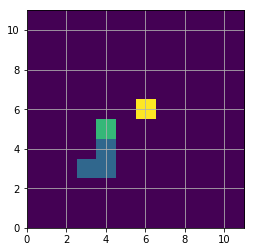

Moving backwards
Hit self


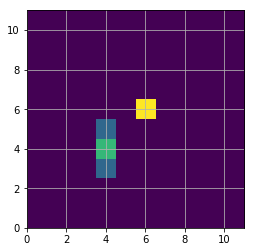

Hit self


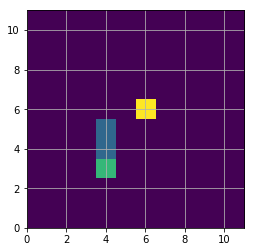

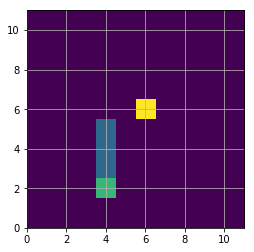

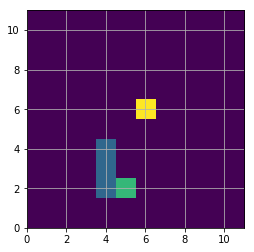

In [17]:
# Move back on self test
moves = ['down', 'down', 'down', 'right']

test_world = get_test_world()
for m in moves:
    plot_world(test_world)
    plt.show()
    test_world, reward, done, info = step_world(test_world, m)
    
plot_world(test_world)
plt.show()

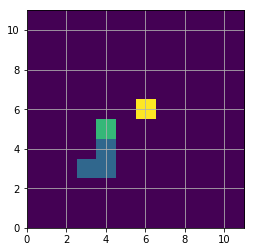

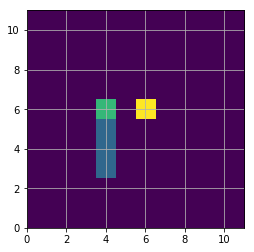

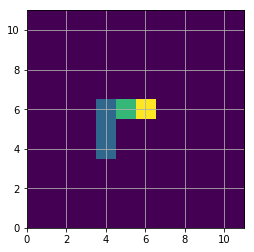

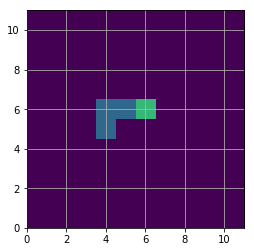

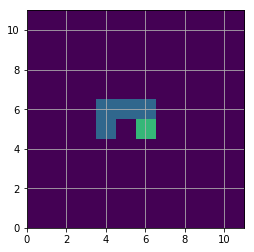

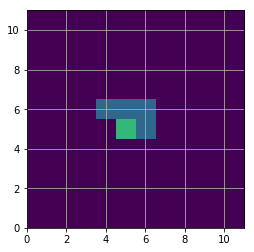

Hit self


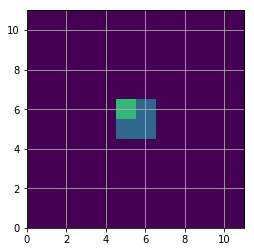

In [8]:
# Hits self test
moves = ['up', 'right', 'right', 'down', 'left', 'up', 'up', 'up']

test_world = get_test_world()
for m in moves:
    plot_world(test_world, mode='single')
    plt.show()
    test_world, reward, done, info = step_world(test_world, m)
    
    if done:
        break
    
plot_world(test_world, mode='single')
plt.show()

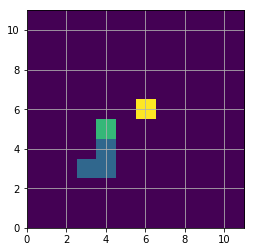

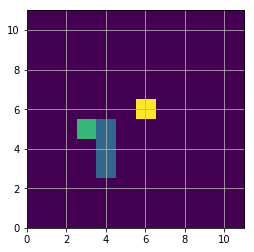

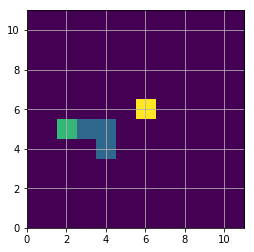

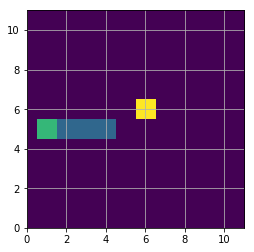

Hit edge


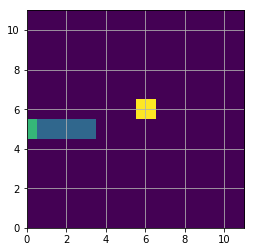

In [9]:
# Hits boundary test
moves = ['left'] * 10

test_world = get_test_world()
for m in moves:
    plot_world(test_world)
    plt.show()
    test_world, reward, done, info = step_world(test_world, m)
    
    if done:
        break
    
plot_world(test_world)
plt.show()

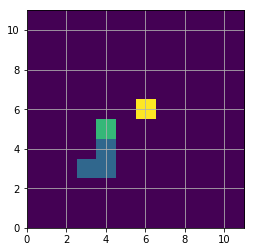

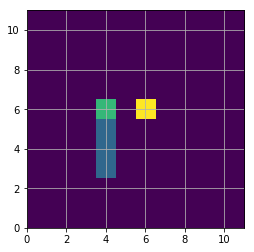

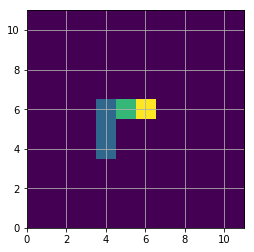

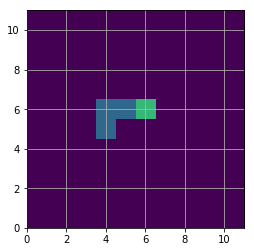

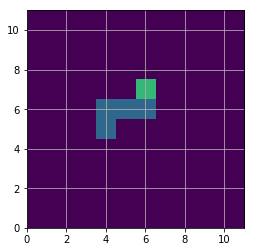

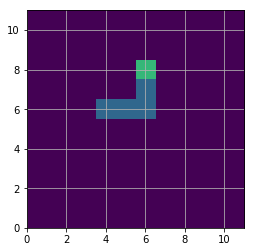

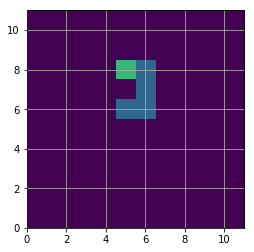

In [10]:
# Food eating test
moves = ['up', 'right', 'right', 'up', 'up', 'left']

test_world = get_test_world()
for m in moves:
    plot_world(test_world, mode='single')
    plt.show()
    test_world, reward, done, info = step_world(test_world, m)

plot_world(test_world, mode='single')
plt.show()

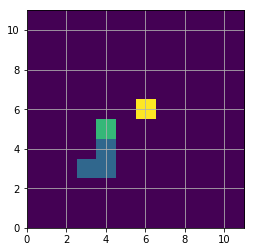

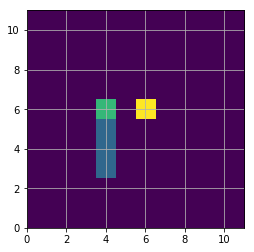

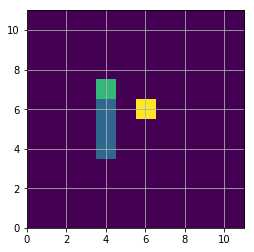

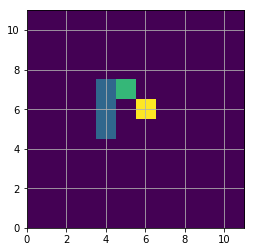

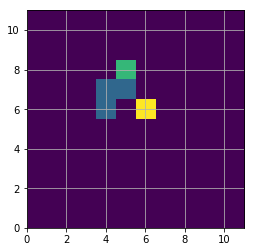

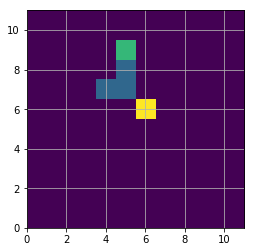

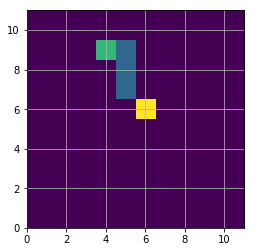

In [11]:
# Generic test
moves = ['up', 'up', 'right', 'up', 'up', 'left']

test_world = get_test_world()
for m in moves:
    plot_world(test_world)
    plt.show()
    
    test_world, reward, done, info = step_world(test_world, m)
    
plot_world(test_world)
plt.show()